In [1]:
import re
import cv2
import time
import random
import plotly.express as px
from tqdm import tqdm
from scipy import signal
import scipy as sp
import scipy.ndimage
import numpy as np
import typing as t
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as k
from tensorflow.keras.models import load_model, Model
from joblib import Parallel, delayed
from skimage.transform import resize
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, CatBoostClassifier

import config as c
import utils.image_processing as ipr
import utils.model as model_factory
from utils.dataset import get_train_data, get_test_data

plt.rcParams["figure.figsize"] = (20, 20)

In [42]:
x, y = get_train_data(available_energy_values=[1, 3, 6, 10, 20, 30], input_shape=(80, 80), values_linear_transformation=False, center_by_max=False, short_load=False)
x = np.array(x)[:,:,:,0]
y = (np.array(y)[:, 1]+np.array(y)[:, 0]*100).reshape((-1, 1)).astype(np.float)

100%|██████████| 6758/6758 [00:00<00:00, 24754.36it/s]


In [3]:
x=x-np.sum((x[:, :25]+x[:, -25:]), axis=1).reshape(-1, 1, 80)/50

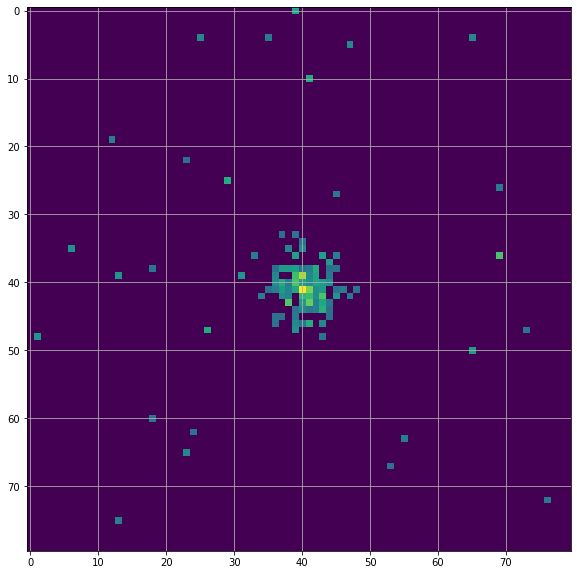

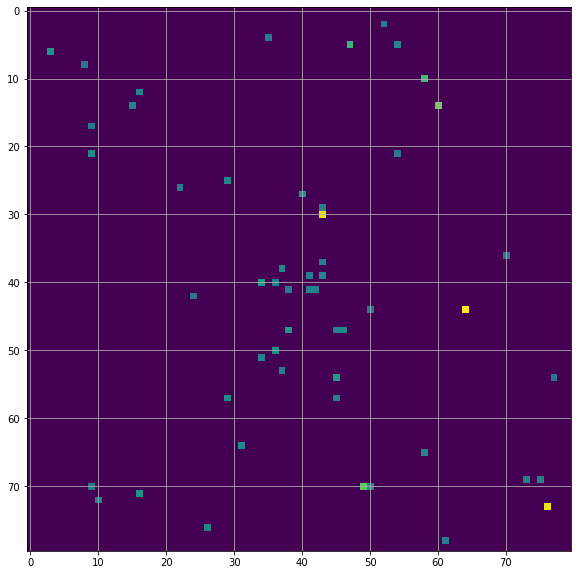

In [4]:
plt.rcParams["figure.figsize"] = (10, 10)
img_0 = random.choice(x[y.reshape(-1)==3])
img_0 = (img_0>12)*img_0
#img_0 = sp.ndimage.filters.gaussian_filter(img_0, [3.0, 3.0])
#img_0 = img_0 ** 2
plt.imshow(img_0)
plt.grid()
plt.show()

img_1 = random.choice(x[y.reshape(-1)==106])
img_1 = (img_1>12)*img_1
#img_1 = sp.ndimage.filters.gaussian_filter(img_1, [3.0, 3.0])
#img_1 = img_1 ** 2
plt.imshow(img_1)
plt.grid()
plt.show()

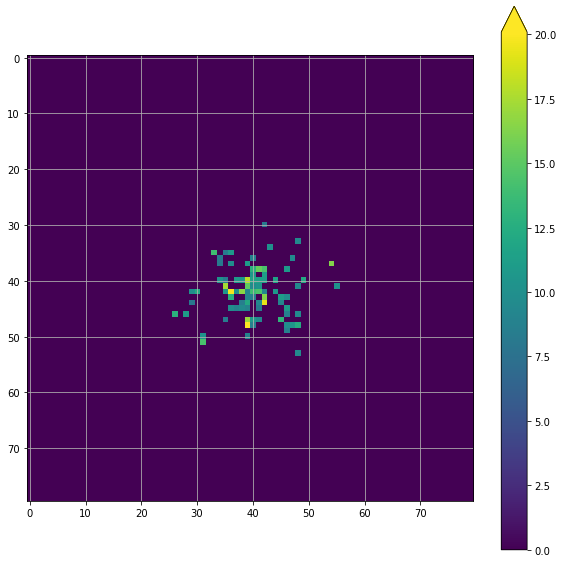

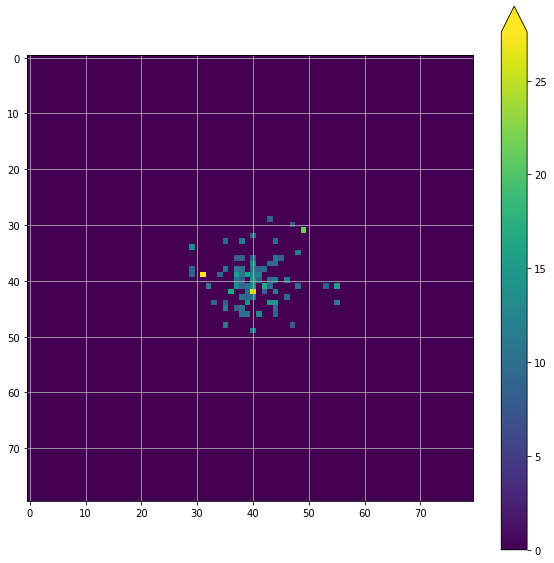

In [11]:
plt.rcParams["figure.figsize"] = (10, 10)
mask = create_circular_mask(80, 80, radius=16)

img_0 = x[y.reshape(-1)==3][59] * mask
img_0 = (img_0>8)*img_0
#img_0 = sp.ndimage.filters.gaussian_filter(img_0, [3.0, 3.0])
#img_0 = img_0 ** 2
pos = plt.imshow(img_0)
plt.colorbar(pos, extend='max')
plt.grid()
plt.show()

img_1 = x[y.reshape(-1)==106][1912] * mask
img_1 = (img_1>8)*img_1
#img_1 = sp.ndimage.filters.gaussian_filter(img_1, [3.0, 3.0])
#img_1 = img_1 ** 2
pos = plt.imshow(img_1)
plt.colorbar(pos, extend='max')
plt.grid()
plt.show()

In [5]:
def create_circular_mask(h, w, center=None, radius=None):
    if center is None:
        center = (int(w/2), int(h/2))
    if radius is None:
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

def get_height_map(img):
    m = np.zeros((30))
    for r in range(0, 30, 2):
        mask = create_circular_mask(80, 80, radius=r) * (~create_circular_mask(80, 80, radius=r-1))
        m[r] = np.sum(mask * img) / np.sum(mask)
    m -= m.min()
    m /= m.max()
    return m

def get_histogram_map(img, radius_0=7, radius_1=30):
    mask = create_circular_mask(80, 80, radius=radius_1) * (~create_circular_mask(80, 80, radius=radius_0))
    m = np.histogram(img[mask], range=(-20, 20), bins=40)[0]
    
    return m

def get_img_spector(img):
    sum_img = np.sum(img*create_circular_mask(80, 80, radius=20)).reshape(-1)
    std_img = np.std(img*create_circular_mask(80, 80, radius=20)).reshape(-1)
    
    histogram_map_0_7 = get_histogram_map(img, 0, 6)
    histogram_map_7_30 = get_histogram_map(img, 6, 30)
    img = sp.ndimage.filters.gaussian_filter(img, [5.0, 5.0])
    
    #gradient = np.abs(np.gradient(resize(img, (20, 20)))[0])[create_circular_mask(20, 20, radius=5)].reshape(-1)
    #gradient = np.abs((np.gradient(img)[0]))#*create_circular_mask(80, 80, radius=20))[20:-20, 20:-20]
    #gradient = resize(gradient, (4, 4))
    #gradient = gradient.reshape(-1)
    #gradient = get_height_map(gradient)
    
    height_map = get_height_map(img)
    spector = np.concatenate([histogram_map_0_7, histogram_map_7_30, height_map, sum_img, std_img])#.reshape(-1, 80)
    return spector

def get_circular_ratio(img):
    img_gaussian = sp.ndimage.filters.gaussian_filter(img.copy(), [3.0, 3.0])
    gaussian_mask = img_gaussian > np.quantile(img_gaussian, 0.995)#112
    r = np.sqrt(np.sum(gaussian_mask)/np.pi)
    mask = create_circular_mask(250, 250, radius=r)
    return np.sum(mask*gaussian_mask)/np.sum(mask+gaussian_mask)

_ = get_img_spector(x[0])

In [6]:
spector_3 = np.array(Parallel(n_jobs=c.NUM_CORES)(delayed(get_img_spector)(img) for img in tqdm(x[y.reshape(-1)==3])))
spector_106 = np.array(Parallel(n_jobs=c.NUM_CORES)(delayed(get_img_spector)(img) for img in tqdm(x[y.reshape(-1)==106])))

train_x = np.concatenate([spector_106, spector_3])
train_y = np.concatenate([np.zeros((len(spector_106), 1)), np.ones((len(spector_3), 1))])

100%|██████████| 2255/2255 [00:05<00:00, 436.70it/s]


In [7]:
x_train, x_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.4, random_state=42)

reg = LinearRegression().fit(x_train, y_train)
reg.score(x_train, y_train)

0.9273502760298097

In [8]:
model = CatBoostRegressor(iterations=100,
                          learning_rate=3e-2,
                          l2_leaf_reg=3.0,  # any pos value
                          depth=5,  # int up to 16
                          min_data_in_leaf=1,  # 1,2,3,4,5
                          rsm=1,  # 0.01 .. 1.0
                          langevin=False,
                          task_type="GPU",
                          devices='0:1')

model.fit(x_train, y_train, eval_set=(x_test, y_test), verbose=0)

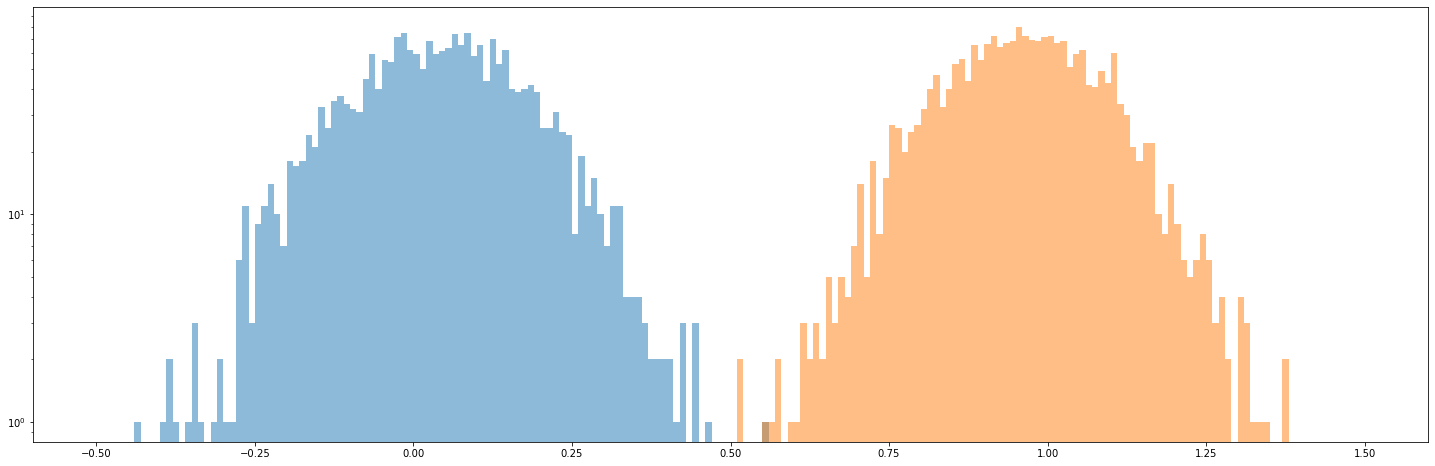

In [9]:
plt.rcParams["figure.figsize"] = (25, 8)
plt.hist(reg.predict(train_x[:len(spector_106)]), bins=200, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.hist(reg.predict(train_x[len(spector_106):]), bins=200, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.show()

In [10]:
spector_1 = np.array(Parallel(n_jobs=c.NUM_CORES)(delayed(get_img_spector)(img) for img in tqdm(x[y.reshape(-1)==1])))
spector_3 = np.array(Parallel(n_jobs=c.NUM_CORES)(delayed(get_img_spector)(img) for img in tqdm(x[y.reshape(-1)==3])))
spector_6 = np.array(Parallel(n_jobs=c.NUM_CORES)(delayed(get_img_spector)(img) for img in tqdm(x[y.reshape(-1)==6])))
spector_10 = np.array(Parallel(n_jobs=c.NUM_CORES)(delayed(get_img_spector)(img) for img in tqdm(x[y.reshape(-1)==10])))
spector_20 = np.array(Parallel(n_jobs=c.NUM_CORES)(delayed(get_img_spector)(img) for img in tqdm(x[y.reshape(-1)==20])))
spector_30 = np.array(Parallel(n_jobs=c.NUM_CORES)(delayed(get_img_spector)(img) for img in tqdm(x[y.reshape(-1)==30])))

spector_101 = np.array(Parallel(n_jobs=c.NUM_CORES)(delayed(get_img_spector)(img) for img in tqdm(x[y.reshape(-1)==101])))
spector_103 = np.array(Parallel(n_jobs=c.NUM_CORES)(delayed(get_img_spector)(img) for img in tqdm(x[y.reshape(-1)==103])))
spector_106 = np.array(Parallel(n_jobs=c.NUM_CORES)(delayed(get_img_spector)(img) for img in tqdm(x[y.reshape(-1)==106])))
spector_110 = np.array(Parallel(n_jobs=c.NUM_CORES)(delayed(get_img_spector)(img) for img in tqdm(x[y.reshape(-1)==110])))
spector_120 = np.array(Parallel(n_jobs=c.NUM_CORES)(delayed(get_img_spector)(img) for img in tqdm(x[y.reshape(-1)==120])))
spector_130 = np.array(Parallel(n_jobs=c.NUM_CORES)(delayed(get_img_spector)(img) for img in tqdm(x[y.reshape(-1)==130])))

100%|██████████| 2/2 [00:00<00:00, 1997.76it/s]


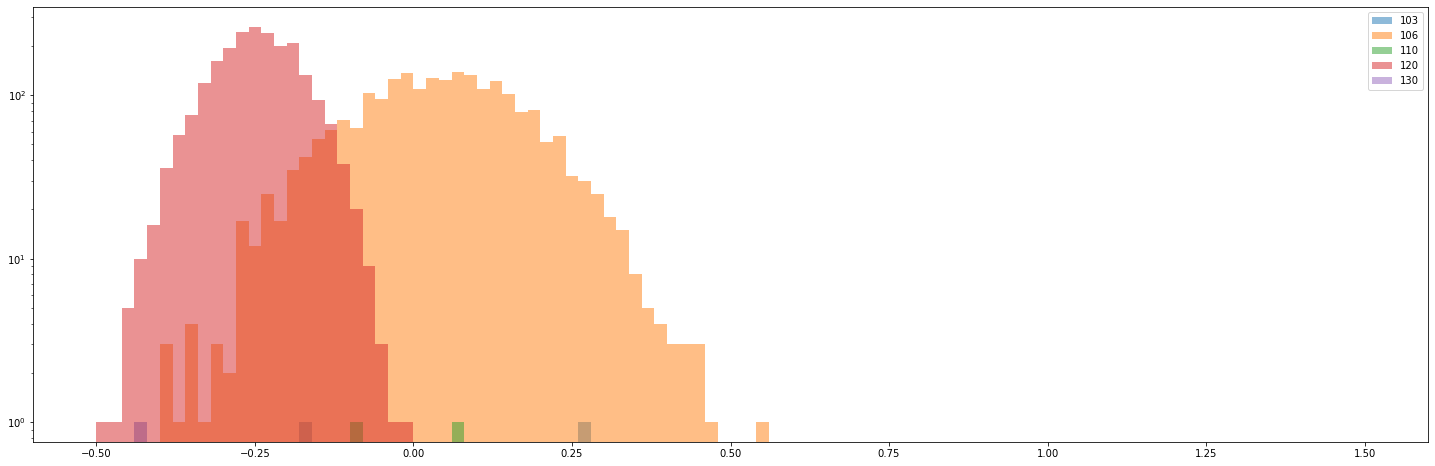

In [11]:
plt.rcParams["figure.figsize"] = (25, 8)
plt.hist(reg.predict(spector_103), bins=100, alpha=0.5, range=(-0.5, 1.5), log=True, label='103')
plt.hist(reg.predict(spector_106), bins=100, alpha=0.5, range=(-0.5, 1.5), log=True, label='106')
plt.hist(reg.predict(spector_110), bins=100, alpha=0.5, range=(-0.5, 1.5), log=True, label='110')
plt.hist(reg.predict(spector_120), bins=100, alpha=0.5, range=(-0.5, 1.5), log=True, label='120')
plt.hist(reg.predict(spector_130), bins=100, alpha=0.5, range=(-0.5, 1.5), log=True, label='130')

#plt.hist(reg.predict(spector_1), bins=100, alpha=0.5, range=(-0.5, 1.5), log=True, label='1')
#plt.hist(reg.predict(spector_3), bins=100, alpha=0.5, range=(-0.5, 1.5), log=True, label='3')
#plt.hist(reg.predict(spector_6), bins=100, alpha=0.5, range=(-0.5, 1.5), log=True, label='6')

plt.legend()
plt.show()

In [13]:
x, y = get_train_data(available_energy_values=[10, 20, 30], input_shape=(250, 250), values_linear_transformation=False, center_by_max=False, short_load=False)
x = np.array(x)[:,:,:,0]
y = (np.array(y)[:, 1]+np.array(y)[:, 0]*100).reshape((-1, 1)).astype(np.float)

x_10 = x[y.reshape(-1)==10]
x_20 = x[y.reshape(-1)==20]
x_30 = x[y.reshape(-1)==30]
x_110 = x[y.reshape(-1)==110]
x_120 = x[y.reshape(-1)==120]
x_130 = x[y.reshape(-1)==130]

100%|██████████| 6758/6758 [00:00<00:00, 26092.73it/s]


In [14]:
x_110 = x[y.reshape(-1)==110]
x_120 = x[y.reshape(-1)==120]
x_130 = x[y.reshape(-1)==130]

In [15]:
circular_ratio_10 = np.array(Parallel(n_jobs=c.NUM_CORES)(delayed(get_circular_ratio)(img) for img in tqdm(x_10)))
circular_ratio_30 = np.array(Parallel(n_jobs=c.NUM_CORES)(delayed(get_circular_ratio)(img) for img in tqdm(x_30)))

circular_ratio_110 = np.array(Parallel(n_jobs=c.NUM_CORES)(delayed(get_circular_ratio)(img) for img in tqdm(x_110)))
circular_ratio_120 = np.array(Parallel(n_jobs=c.NUM_CORES)(delayed(get_circular_ratio)(img) for img in tqdm(x_120)))
circular_ratio_130 = np.array(Parallel(n_jobs=c.NUM_CORES)(delayed(get_circular_ratio)(img) for img in tqdm(x_130)))

100%|██████████| 2/2 [00:00<00:00, 2001.10it/s]


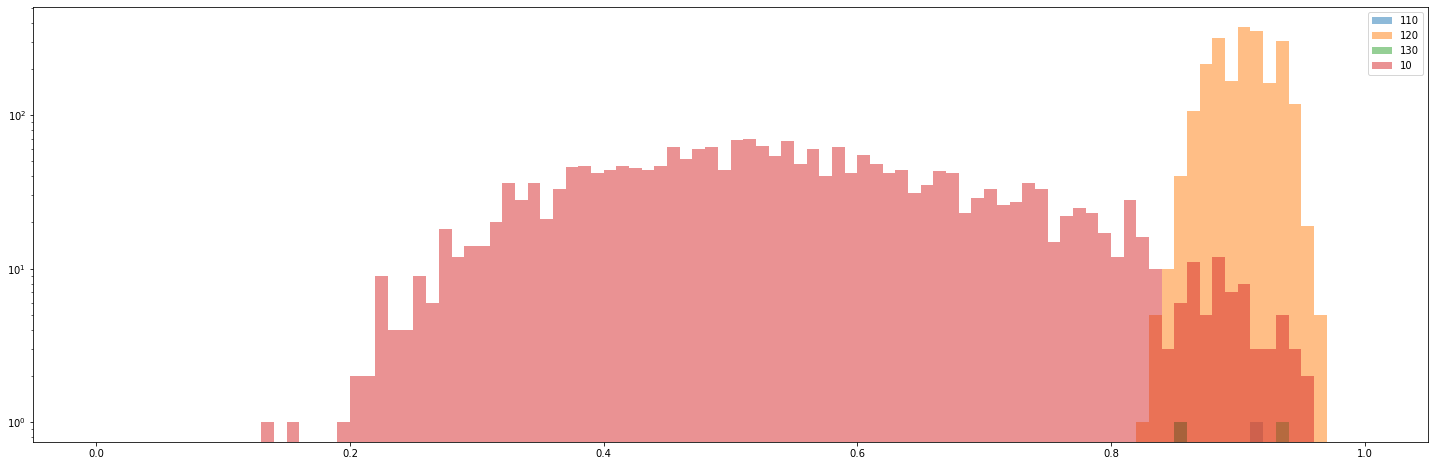

In [16]:
plt.rcParams["figure.figsize"] = (25, 8)
plt.hist(circular_ratio_110, bins=100, alpha=0.5, range=(0, 1), log=True, label='110')
plt.hist(circular_ratio_120, bins=100, alpha=0.5, range=(0, 1), log=True, label='120')
plt.hist(circular_ratio_130, bins=100, alpha=0.5, range=(0, 1), log=True, label='130')
plt.hist(circular_ratio_10, bins=100, alpha=0.5, range=(0, 1), log=True, label='10')

plt.legend()
plt.show()

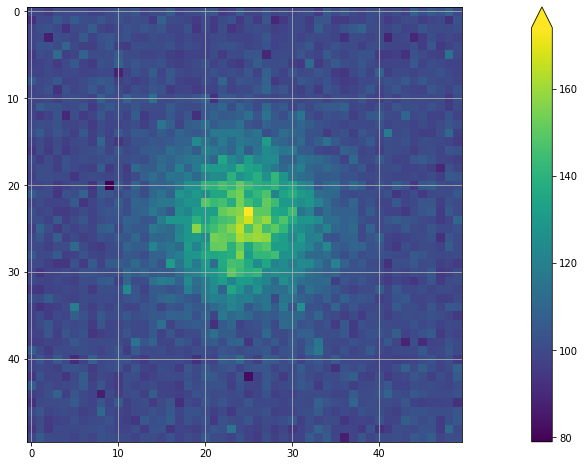

In [39]:
img = x_120[circular_ratio_120<0.90][0]
#img = sp.ndimage.filters.gaussian_filter(img.copy(), [3.0, 3.0])
pos = plt.imshow(img[100:150, 100:150])
plt.colorbar(pos, extend='max')
plt.grid()
plt.show()

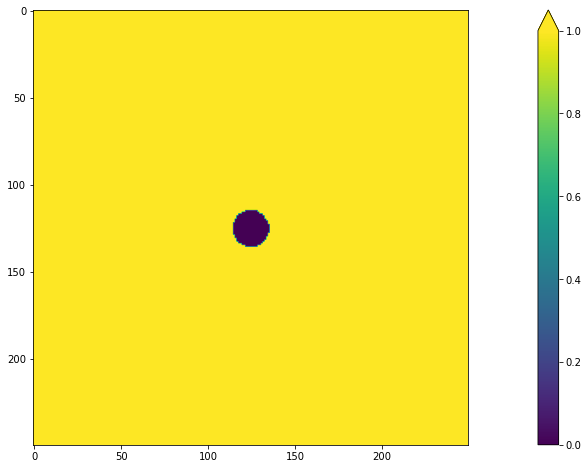

In [18]:
img = x_120[circular_ratio_120<0.9][0]
#img = x_30[circular_ratio_30>0.85][0]
img = x_10[circular_ratio_10>0.9][0]

img_gaussian = sp.ndimage.filters.gaussian_filter(img.copy(), [3.0, 3.0])
gaussian_mask = img_gaussian > 105
r = np.sqrt(np.sum(gaussian_mask)/np.pi)
mask = create_circular_mask(250, 250, radius=r)


pos = plt.imshow((gaussian_mask*1 + mask*2)<3)
plt.colorbar(pos, extend='max')
plt.show()

In [ ]:
pos = plt.imshow(img*mask)
plt.colorbar(pos, extend='max')
plt.show()

pos = plt.imshow(img*gaussian_mask)
plt.colorbar(pos, extend='max')
plt.show()

In [233]:
spector_106.shape

(2, 1600)

In [11]:
print(np.argmin(r_3[0]), np.argmax(r_3[0]), np.argmin(r_106[0]), np.argmax(r_106[0]))

NameError: name 'r_3' is not defined

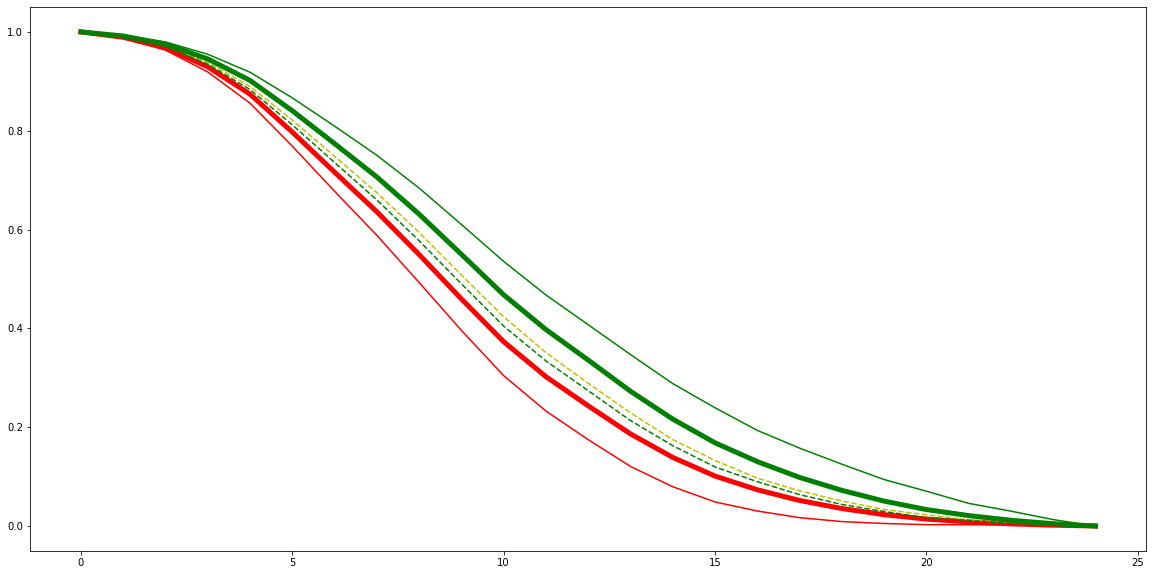

In [126]:
plt.rcParams["figure.figsize"] = (20, 10)
#line, = plt.plot(np.transpose(spector_3)[:,248], color='r')

line, = plt.plot(spector_3[1692], color='r')
line, = plt.plot(np.mean(np.transpose(spector_3), axis=1), color='r', linewidth=5)
line, = plt.plot(spector_3[59], color='y', linestyle='--')

line, = plt.plot(np.transpose(spector_106)[:,1912], color='g', linestyle='--')
line, = plt.plot(np.transpose(spector_106)[:,1349], color='g', linestyle='-')
line, = plt.plot(np.mean(np.transpose(spector_106), axis=1), color='g', linewidth=5)

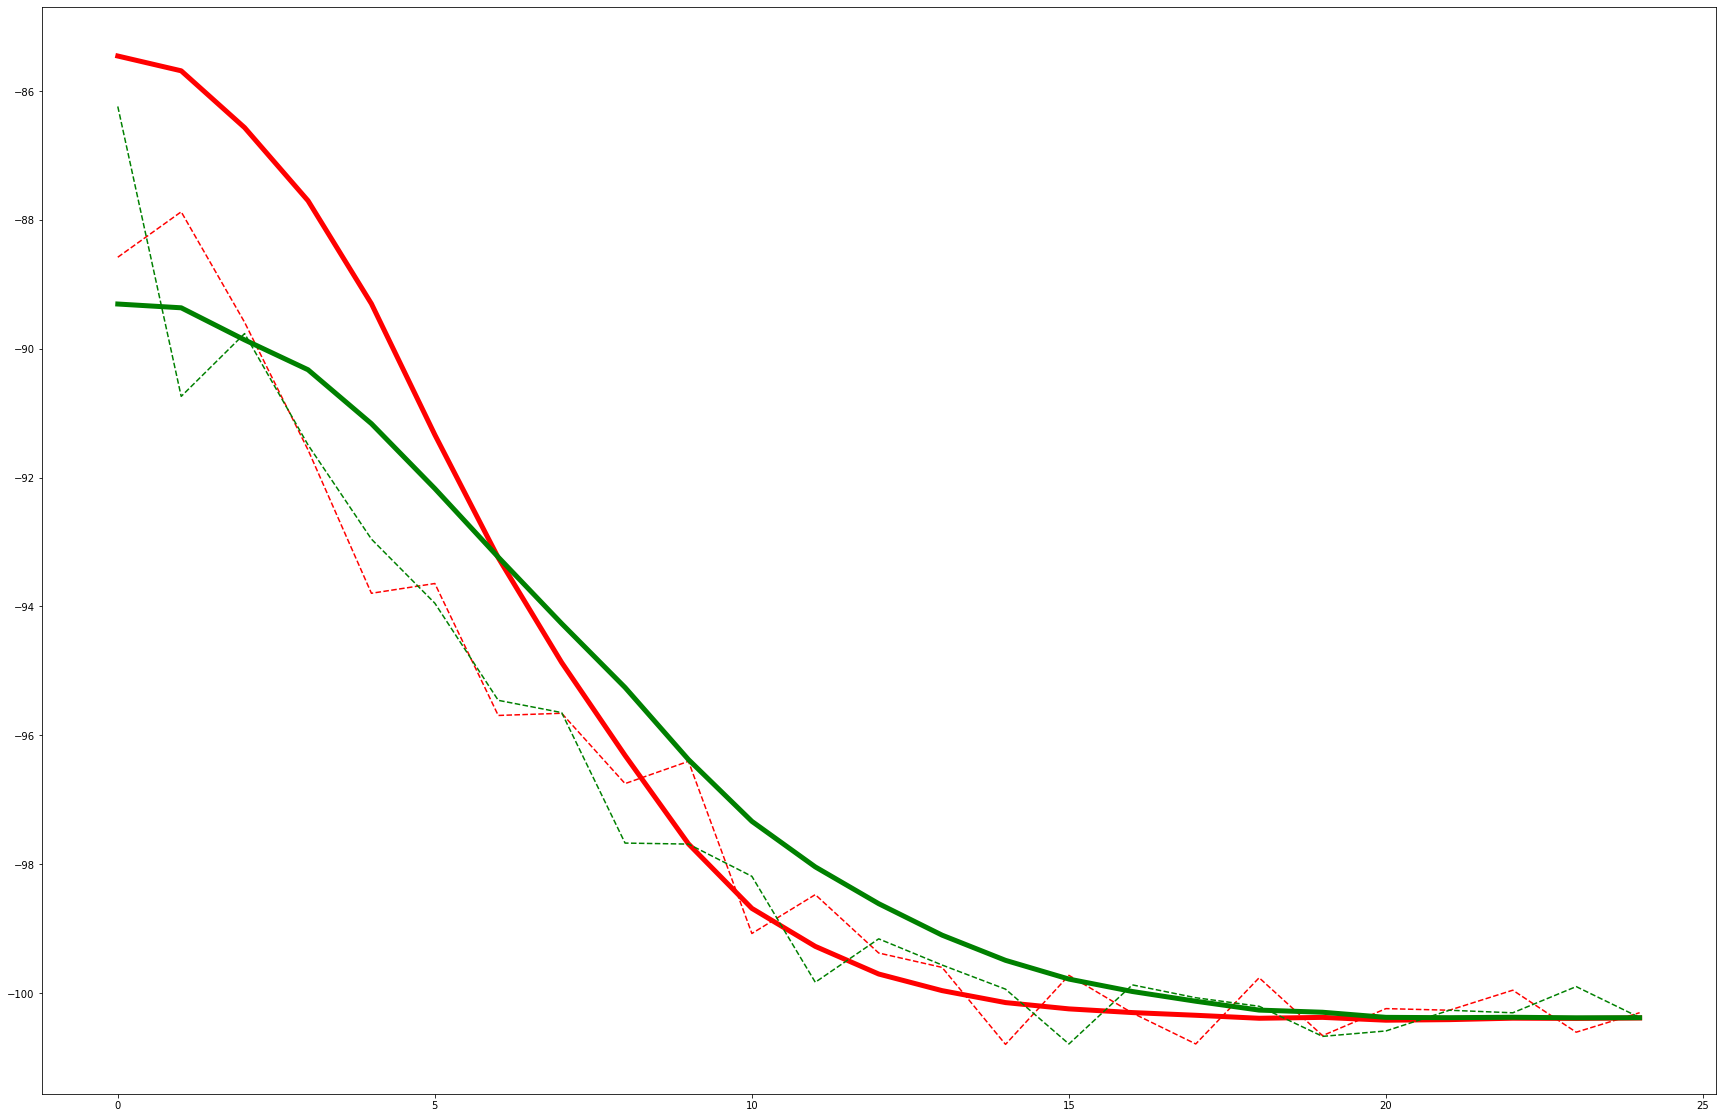

In [182]:
plt.rcParams["figure.figsize"] = (30, 20)
#line, = plt.plot(np.transpose(spector_3)[:,248], color='r')

#line, = plt.plot(spector_3[1692], color='r')
line, = plt.plot(np.mean(np.transpose(spector_3), axis=1), color='r', linewidth=5)
line, = plt.plot(spector_3[59], color='r', linestyle='--')

line, = plt.plot(np.transpose(spector_106)[:,1912], color='g', linestyle='--')
#line, = plt.plot(np.transpose(spector_106)[:,1349], color='g', linestyle='-')
line, = plt.plot(np.mean(np.transpose(spector_106), axis=1), color='g', linewidth=5)

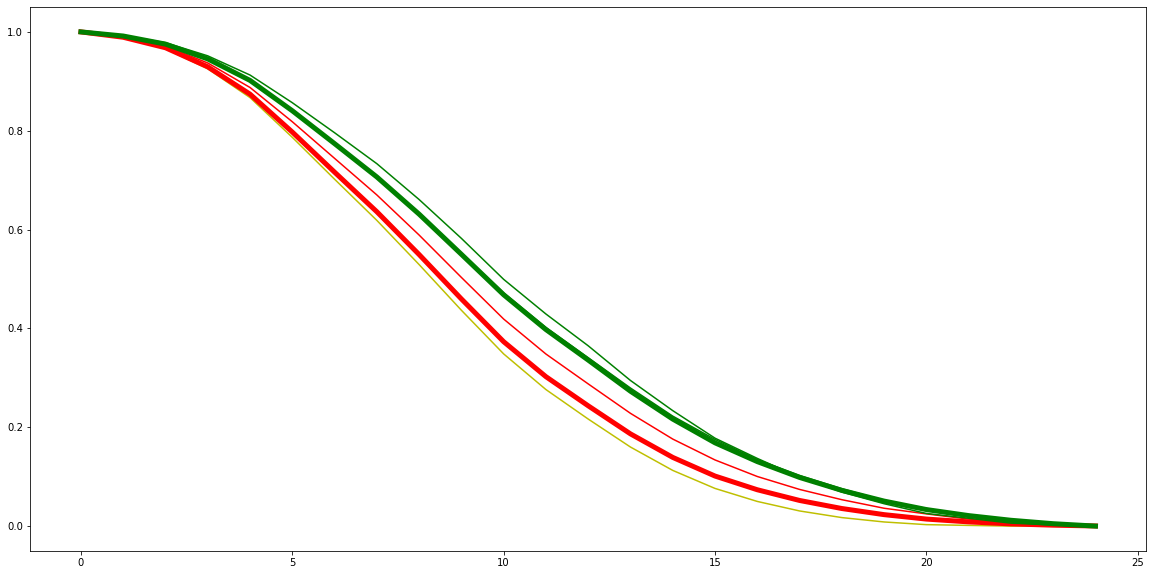

In [94]:
plt.rcParams["figure.figsize"] = (20, 10)
#line, = plt.plot(np.transpose(spector_3)[:,248], color='r')
line, = plt.plot(spector_3[2034], color='r')
line, = plt.plot(spector_3[248], color='y')
line, = plt.plot(np.mean(np.transpose(spector_3), axis=1), color='r', linewidth=5)

line, = plt.plot(np.transpose(spector_106)[:,2202], color='g')
line, = plt.plot(np.transpose(spector_106)[:,49], color='g')
line, = plt.plot(np.mean(np.transpose(spector_106), axis=1), color='g', linewidth=5)

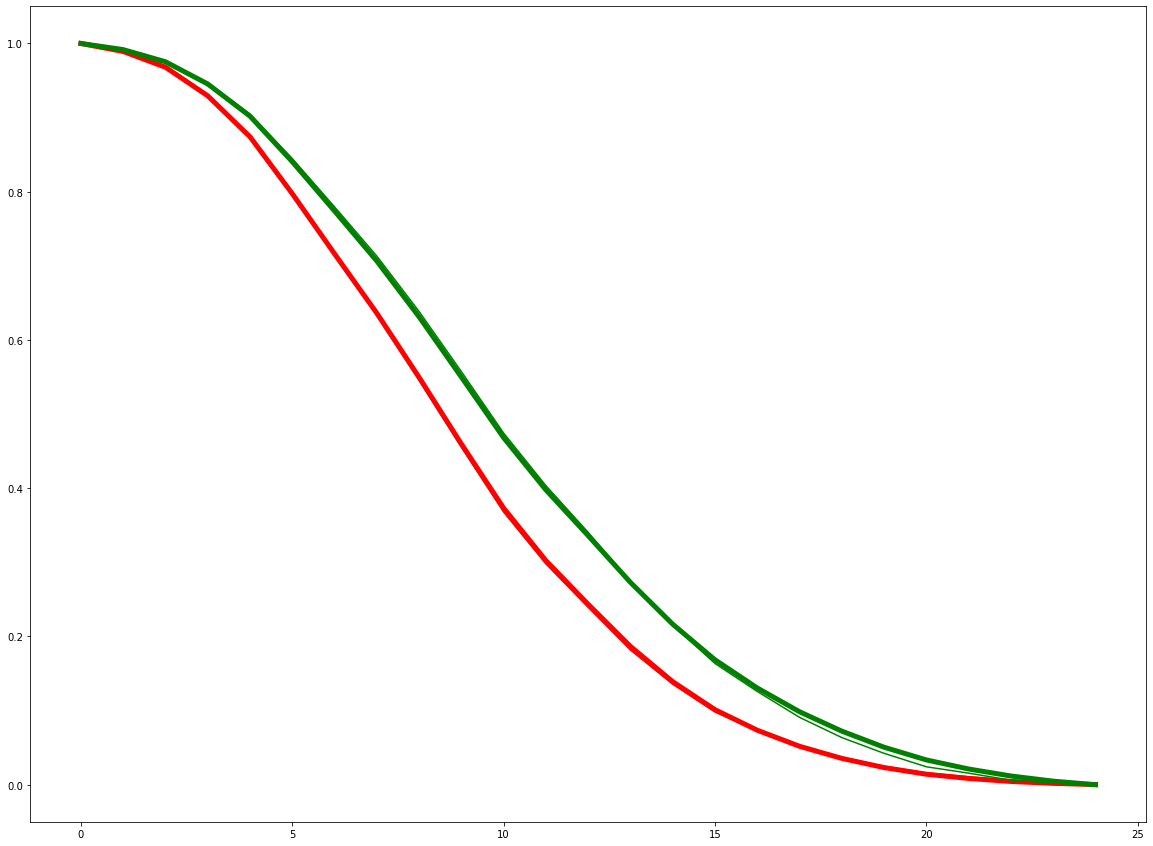

In [95]:
plt.rcParams["figure.figsize"] = (20, 15)
#plt.axis((0,25,0,14))
plt.plot(np.transpose(spector_3)[:,random.randint(0, 2000)], color='r')
plt.plot(np.mean(np.transpose(spector_3), axis=1), color='r', linewidth=5)

plt.plot(np.transpose(spector_106)[:,random.randint(0, 2000)], color='g')
plt.plot(np.mean(np.transpose(spector_106), axis=1), color='g', linewidth=5)

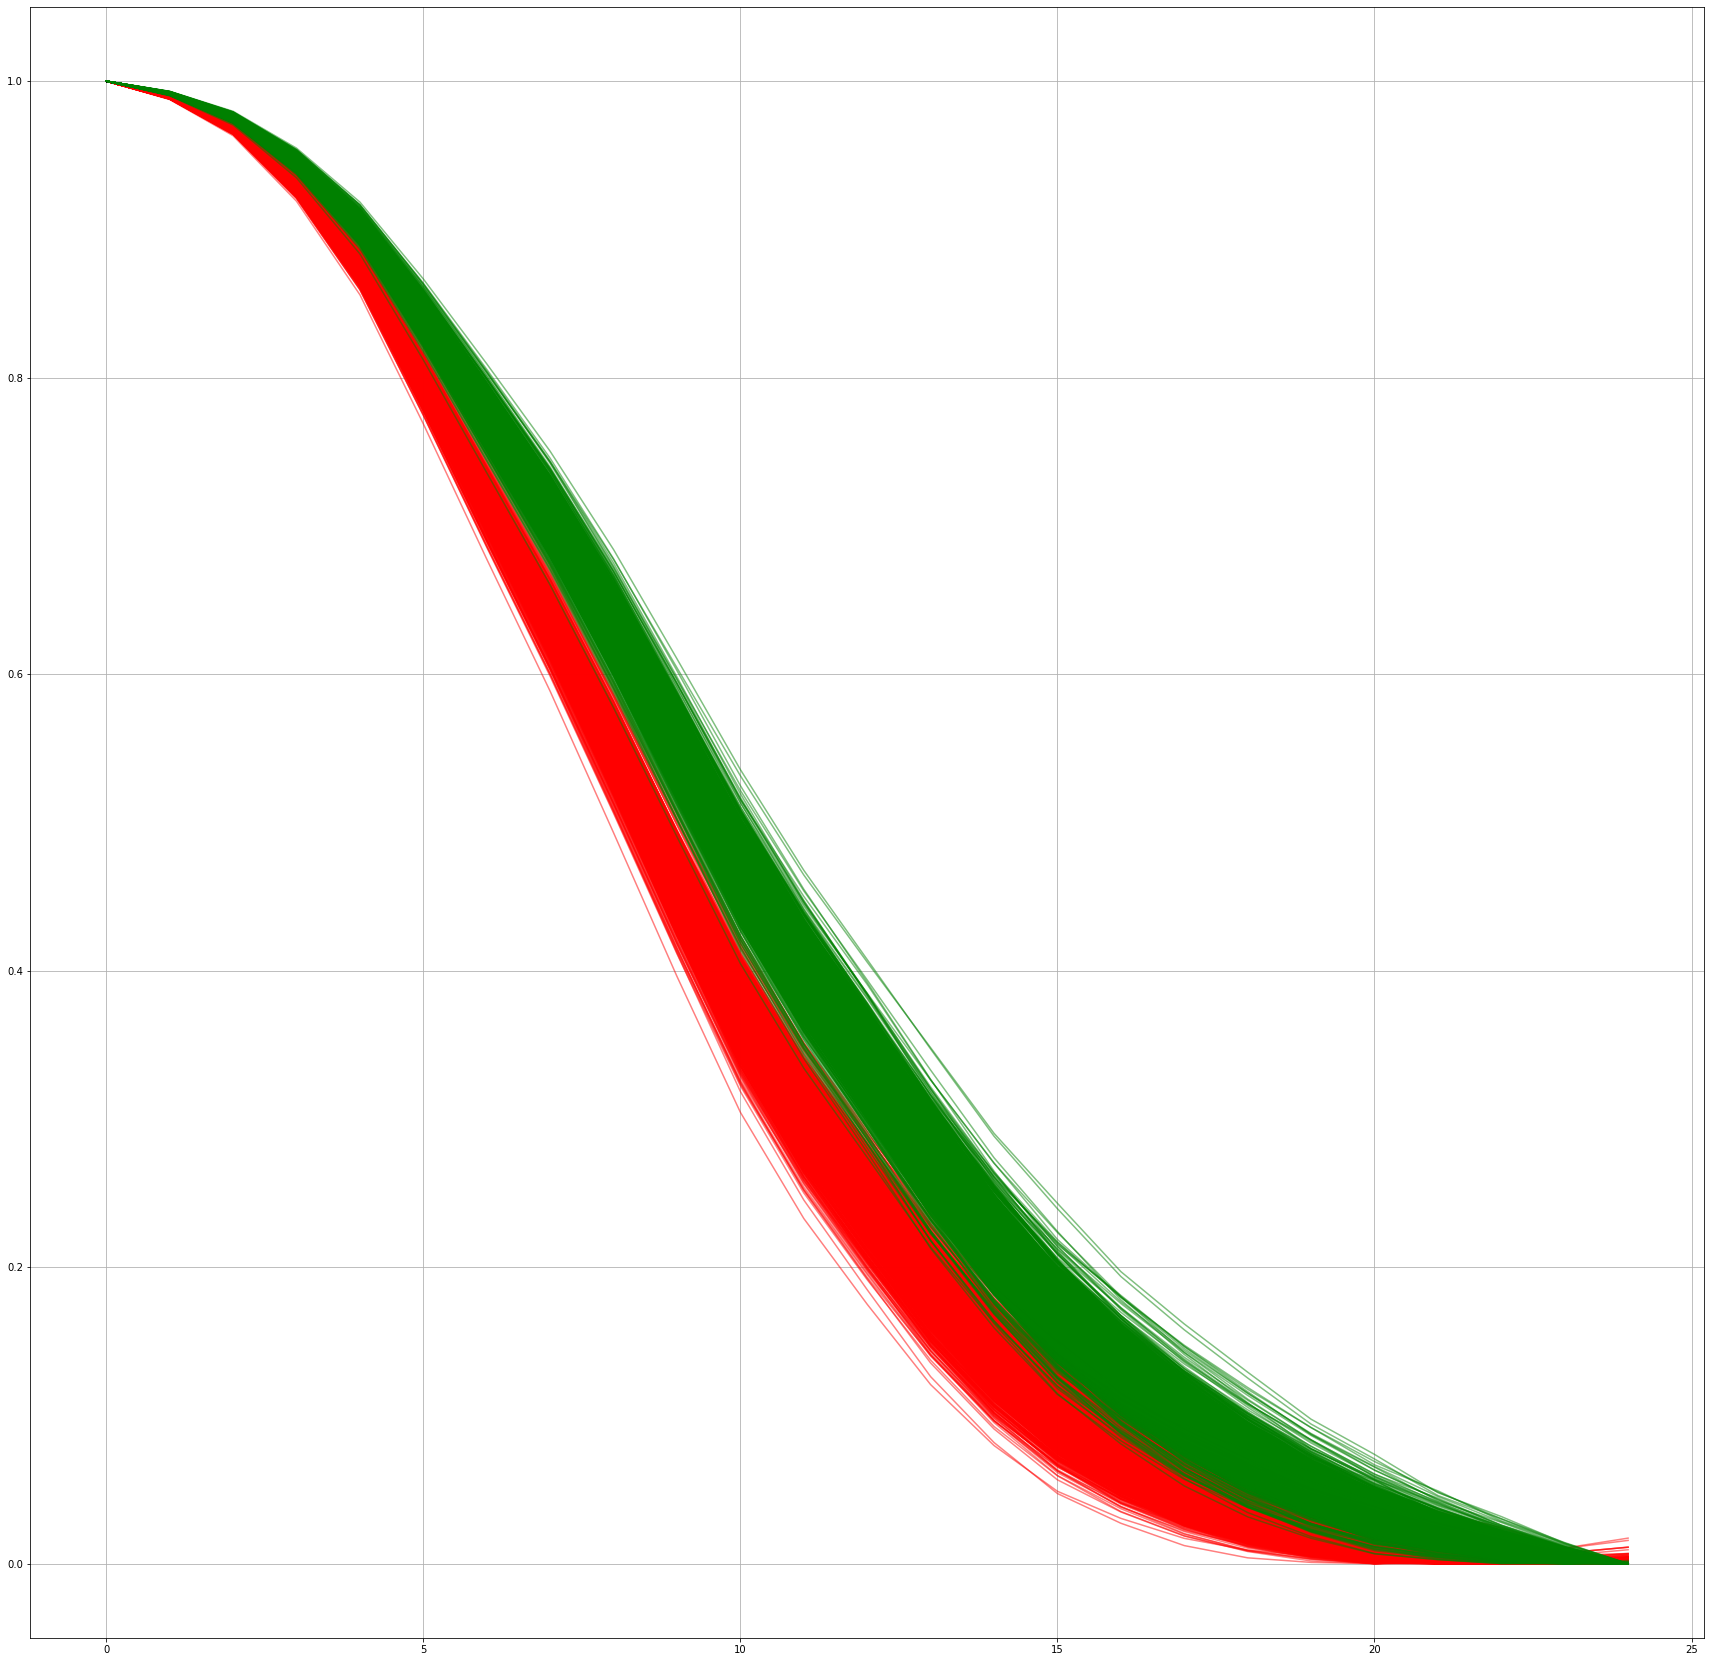

In [127]:
plt.rcParams["figure.figsize"] = (30, 30)
plt.plot(np.transpose(spector_3), color='r', alpha=0.5)
plt.plot(np.transpose(spector_106), color='g', alpha=0.5)
plt.grid()
plt.show()